In [112]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage
import pandas as pd

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import struct
K.set_image_data_format('channels_last')
import sys
print("Python:", sys.version, "Keras:", keras.__version__, "TF:", tf.__version__)

Python: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:23:14) [GCC 10.4.0] Keras: 2.8.0 TF: 2.8.4


# *Data Pre-processing*

In [32]:
test = pn.read_csv('./data/sign_mnist_train.csv')
train = pn.read_csv('./data/sign_mnist_test.csv')

In [33]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [34]:
train.shape,test.shape

((7172, 785), (27455, 785))

In [105]:
y_train =train['label']
y_test =test['label']
x_train=train.drop('label',axis=1)
x_test=test.drop('label',axis=1)
testY = np.array(test['label'])

In [106]:
x_train = x_train / 255
x_test = x_test / 255

In [107]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_test=lb.fit_transform(y_test)

In [108]:
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

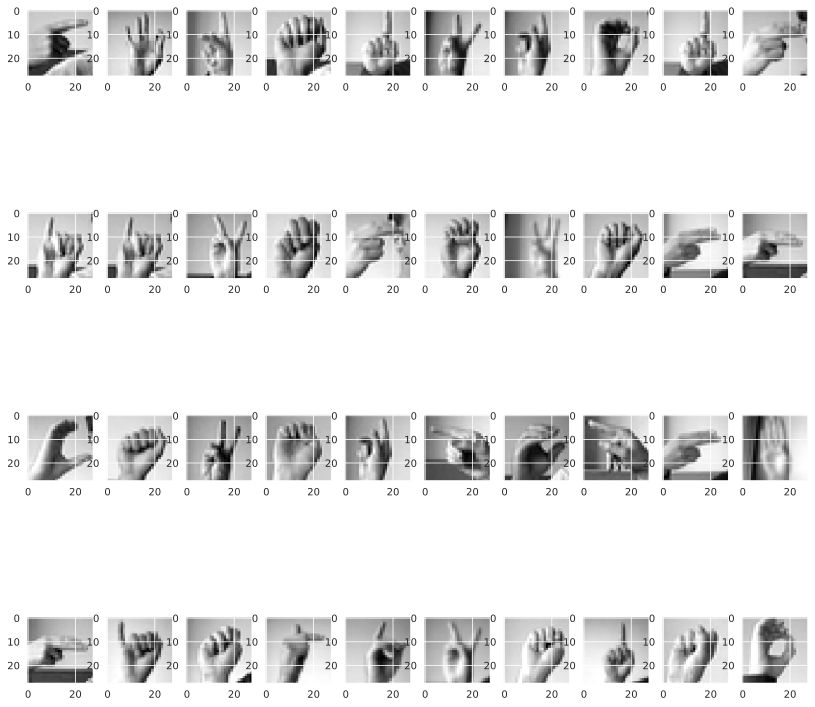

In [68]:
plt.figure(figsize=(14,14))
x, y = 10, 4 
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
plt.show()

# *Data Augmentation*

In [85]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

In [86]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

# *CNN model*

In [95]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(x_train, y_train, 
  train_size=0.8, test_size=0.2, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(vtrainI.shape)
print(validI.shape)
print(vtrainYb.shape)

(5737, 28, 28, 1)
(1435, 28, 28, 1)
(5737, 24)


In [78]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'accuracy' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [96]:
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

model = Sequential()
model.add(Conv2D(10, (5,5), strides=(2,2), activation='relu',
    padding='same', input_shape=(28,28,1), kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(Conv2D(40, (5,5), strides=(2,2), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(Conv2D(80, (5,5), strides=(1,1), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(Flatten())
model.add(Dense(units=50, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)))
model.add(Dense(units=24, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.0001)))

earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',
               min_delta=0.0001, patience=20,
               verbose=1, mode='auto')
callbacks_list = [earlystop]

model.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True), 
           metrics=['accuracy']
          )

history = model.fit(datagen.flow(vtrainI, vtrainYb, batch_size=50),
                 steps_per_epoch=len(vtrainI)/50,
                 epochs=50,
                 callbacks=callbacks_list, 
                 validation_data=validsetI,
                 verbose=True)

# history = model.fit(vtrainI, vtrainYb, epochs=100, batch_size=50,
#                  callbacks=callbacks_list,
#                  validation_data=validsetI,
#                  verbose=True)

Epoch 1/50
114/114 [==============================] - 18s 153ms/step - loss: 3.1571 - accuracy: 0.0610 - val_loss: 3.1011 - val_accuracy: 0.0780
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 2.7086 - accuracy: 0.2055 - val_loss: 1.9801 - val_accuracy: 0.3596
Epoch 3/50
114/114 [==============================] - 2s 21ms/step - loss: 1.8190 - accuracy: 0.4321 - val_loss: 1.3589 - val_accuracy: 0.5624
Epoch 4/50
114/114 [==============================] - 3s 22ms/step - loss: 1.3038 - accuracy: 0.5857 - val_loss: 0.7687 - val_accuracy: 0.7742
Epoch 5/50
114/114 [==============================] - 3s 22ms/step - loss: 0.8803 - accuracy: 0.7215 - val_loss: 0.4260 - val_accuracy: 0.8544
Epoch 6/50
114/114 [==============================] - 3s 30ms/step - loss: 0.5885 - accuracy: 0.8145 - val_loss: 0.2956 - val_accuracy: 0.9115
Epoch 7/50
114/114 [==============================] - 3s 27ms/step - loss: 0.4547 - accuracy: 0.8616 - val_loss: 0.1335 - val_accuracy: 0.97

[22  7  2 ... 17 16 22]
[ 3  6  2 ... 18 17 23]
test accuracy: 0.30537242760881445


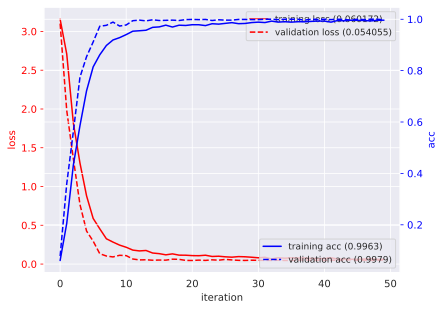

In [117]:
plot_history(history)
predY = argmax(model.predict(x_test, verbose=False), axis=-1)
print(predY)
print(testY)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# *TP Matrix*

In [119]:
# # get TP matrix
# label_df = pd.DataFrame({
#     'True':testY,
#     'Pred':predY
# })

# # get True Positive for each label
# def cal_TP_matrix(label_df):
#     TP_matrix = np.zeros((24,24))

#     for lb in labels:
#         ture_count = label_df.loc[label_df['True'] == lb].groupby('Pred').agg(
#             'count')
#         for pred_idx, row in ture_count.iterrows():
#             lb_idx = lb if lb < 9 else lb-1
#             pred_idx = pred_idx if pred_idx < 9 else pred_idx-1
#             TP_matrix[lb_idx][pred_idx] = row[0]

#     return TP_matrix

# def cal_TPR(label_df):
#     RP = label_df.groupby('True').agg('count')
#     PP = label_df.groupby('Pred').agg('count')
#     TP = label_df.loc[label_df['True']==label_df['Pred']].groupby('True').agg('count')
    
#     precision = np.array(TP).T[0] / np.array(PP).T[0]
#     recall = np.array(TP).T[0] / np.array(RP).T[0]
#     return precision, recall

# cal_TPR(label_df)

In [120]:
# pd.options.display.max_columns = None

# label_index = [i for i in label_index]
# TPmx = cal_TP_matrix(label_df)
# pd.DataFrame(TPmx, label_index, label_index)